In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms , models
from torch.utils.data import DataLoader 

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [3]:
train_data = datasets.ImageFolder(root='dataset/train', transform=transform)
test_data = datasets.ImageFolder(root='dataset/test', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=2)
model = model.to(device)

In [6]:
for param in model.features.parameters():
    param.requires_grad = False

for params in model.features[-5:].parameters():
    params.requires_grad = True

for params in model.classifier.parameters():
    params.requires_grad = True

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

In [8]:
def train(model,loader):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

In [9]:
def evalution(model,loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [10]:
import matplotlib.pyplot as plt

train_losses = []
test_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader)
    test_accuracy = evalution(model, test_loader)
    
    train_losses.append(train_loss)
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.6f}, Test Accuracy: {test_accuracy:.2f}%')

Epoch [1/10], Loss: 0.574814, Test Accuracy: 92.86%
Epoch [2/10], Loss: 0.310235, Test Accuracy: 92.86%
Epoch [3/10], Loss: 0.191452, Test Accuracy: 94.29%
Epoch [4/10], Loss: 0.125273, Test Accuracy: 96.43%
Epoch [5/10], Loss: 0.080249, Test Accuracy: 95.71%
Epoch [6/10], Loss: 0.069506, Test Accuracy: 95.00%
Epoch [7/10], Loss: 0.064774, Test Accuracy: 95.71%
Epoch [8/10], Loss: 0.033856, Test Accuracy: 95.00%
Epoch [9/10], Loss: 0.038758, Test Accuracy: 97.14%
Epoch [10/10], Loss: 0.051502, Test Accuracy: 95.00%


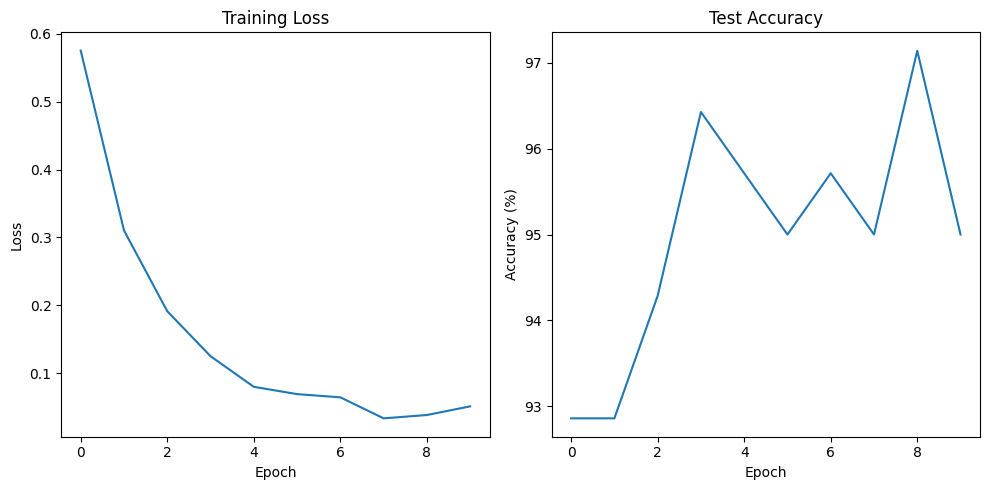

In [11]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(test_accuracies)
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()

In [12]:
torch.save(model.state_dict(), 'vgg16_cat_dog.pth')

In [13]:
from PIL import Image

def predict_image(image_path, model):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    
    classes = ['Cat', 'Dog']
    print(f"Predicted: {classes[predicted.item()]}")

In [17]:
predict_image('789.jpg', model)

Predicted: Dog
